In [ ]:
1. Realizar un análisis exploratorio de los datos para identificar relaciones entre variables, valores atípicos, tendencias, etc.

In [62]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, RFE
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

In [70]:
data = pd.read_csv('C:/Users/saaanti/Downloads/archive (3)/winequality-red.csv')

In [72]:
# Examinamos las primeras filas
print("Primeras filas del dataset:")
print(data.head())

# Información general del dataset
print("\nInformación del dataset:")
print(data.info())

# Estadísticas descriptivas
print("\nEstadísticas descriptivas:")
print(data.describe())

# Verificar valores nulos
print("\nSuma de valores nulos por columna:")
print(data.isnull().sum())

Primeras filas del dataset:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8    

In [ ]:
# 2. ANÁLISIS EXPLORATORIO DE DATOS (EDA)

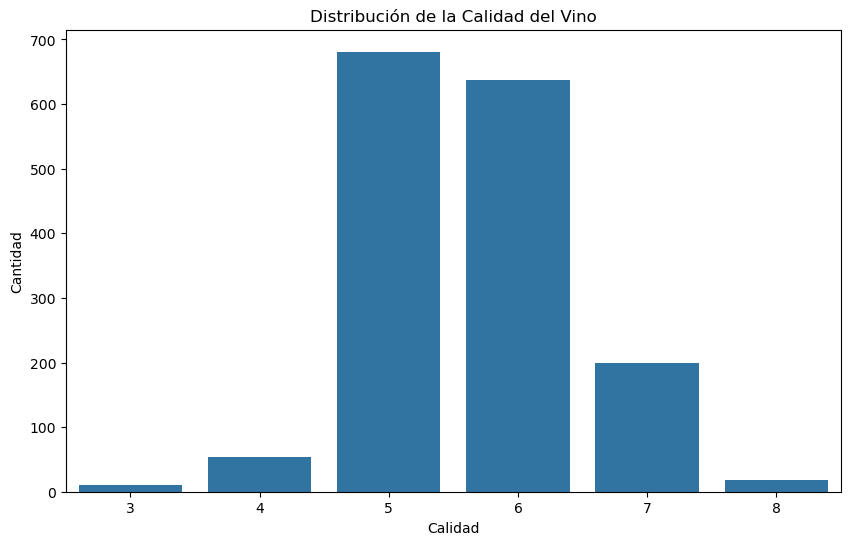

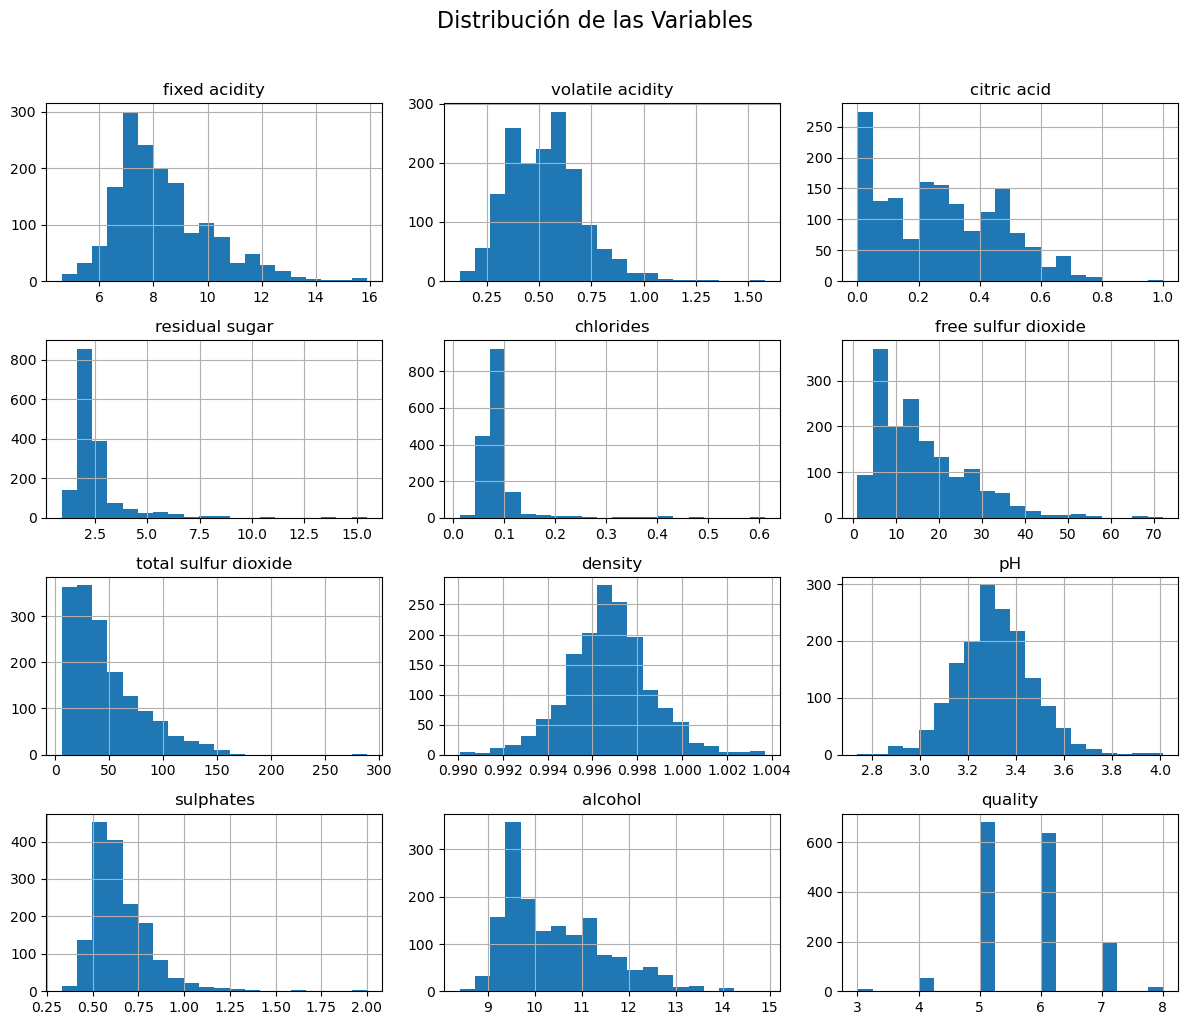

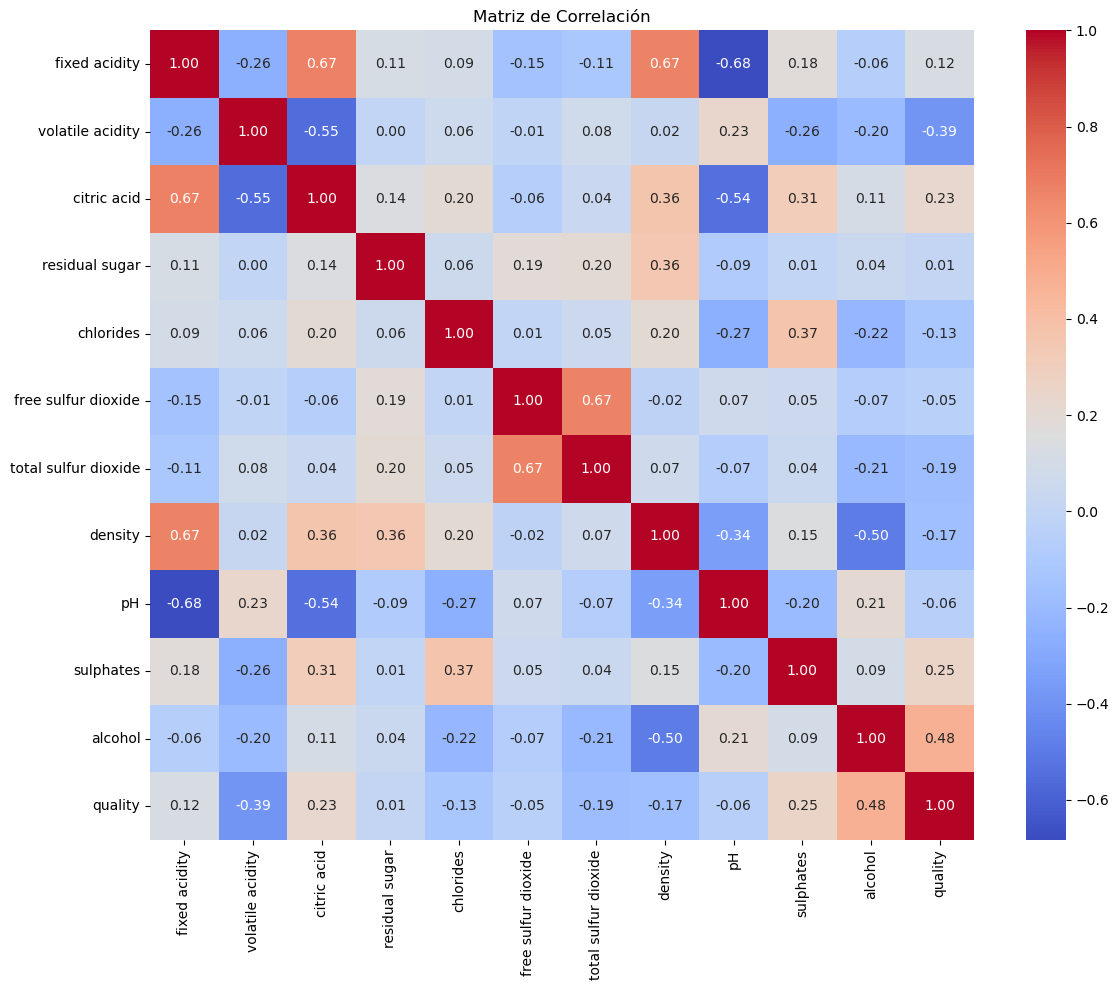

In [74]:
# Distribución de la variable objetivo (calidad)
plt.figure(figsize=(10, 6))
sns.countplot(x='quality', data=data)
plt.title('Distribución de la Calidad del Vino')
plt.xlabel('Calidad')
plt.ylabel('Cantidad')
plt.show()

# Histogramas de todas las características
data.hist(figsize=(12, 10), bins=20)
plt.suptitle('Distribución de las Variables', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# Matriz de correlación
plt.figure(figsize=(12, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.tight_layout()
plt.show()

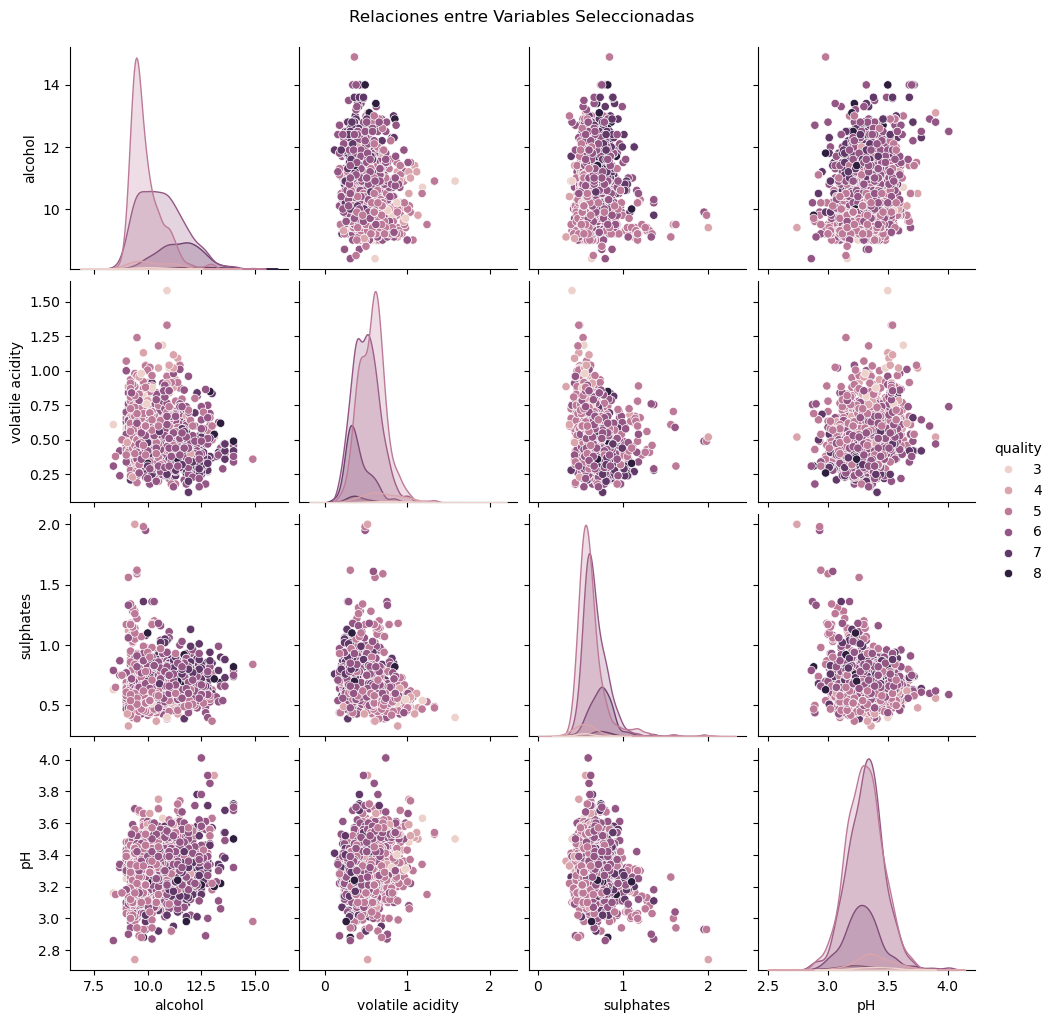

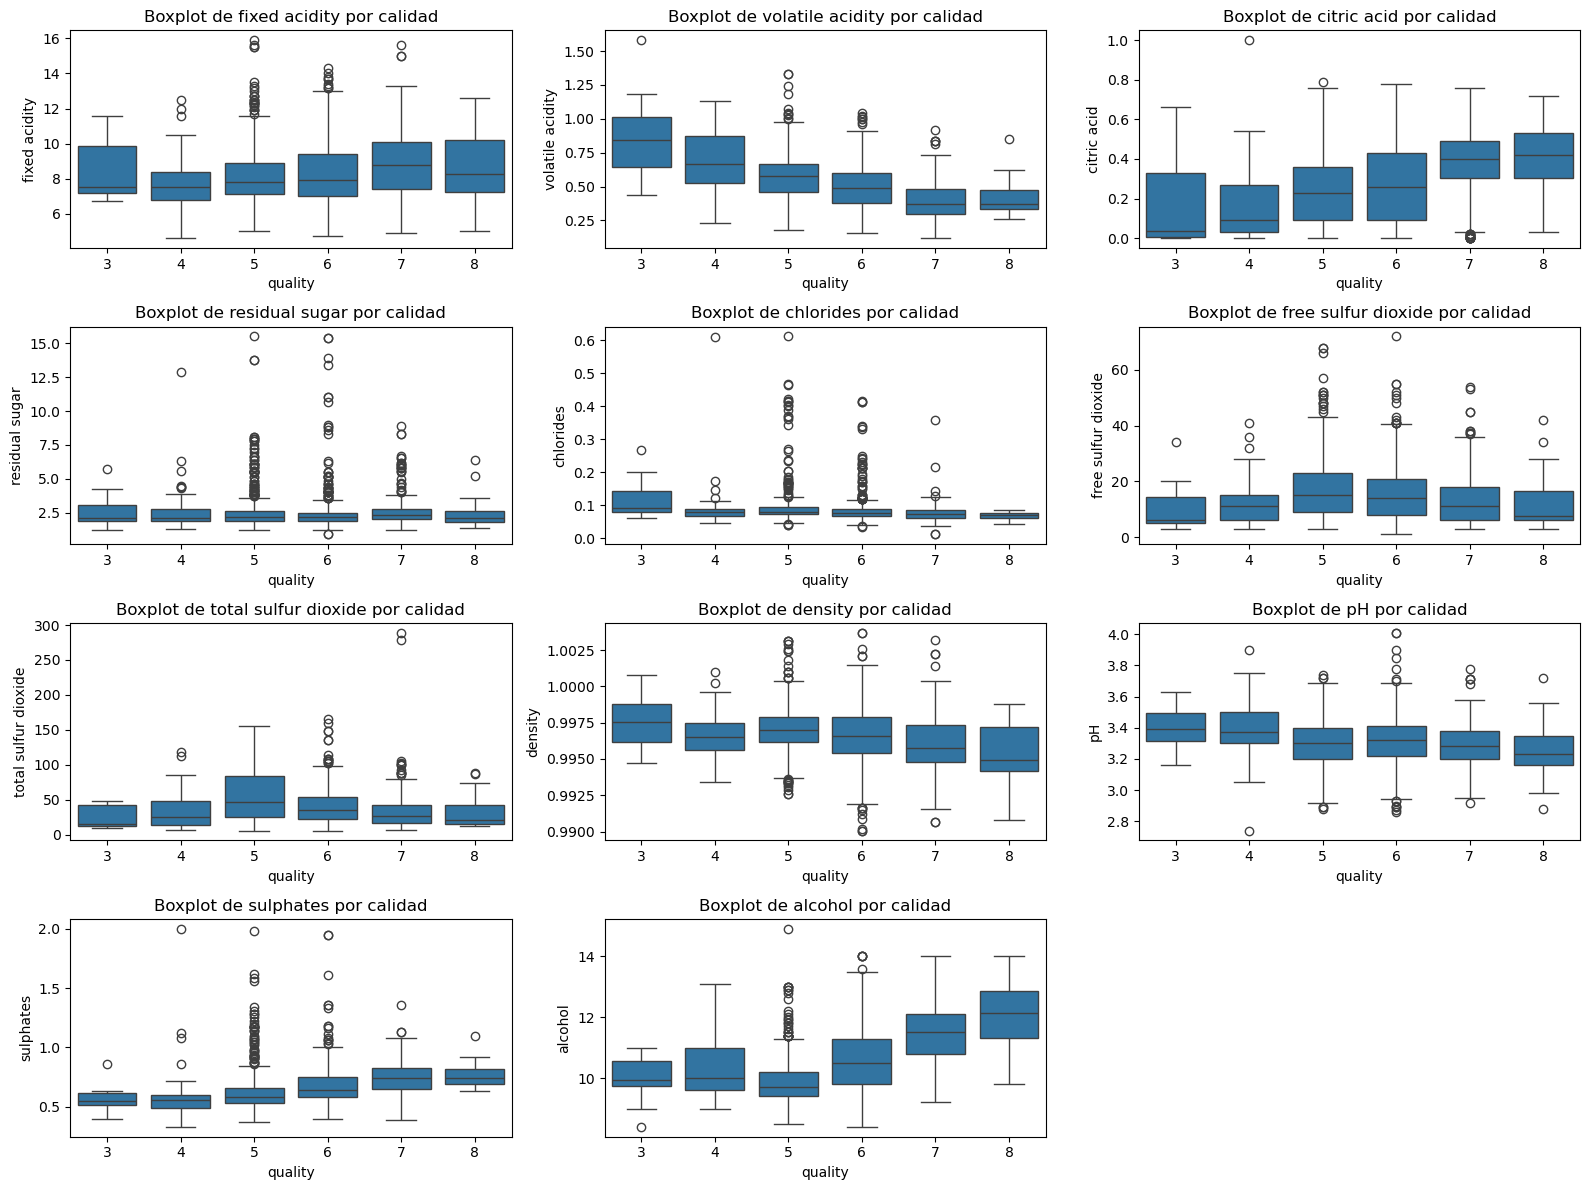

In [76]:
# Pairs plot para visualizar relaciones entre variables
# Seleccionamos solo algunas variables para evitar una gráfica muy grande
selected_features = ['alcohol', 'volatile acidity', 'sulphates', 'pH', 'quality']
sns.pairplot(data[selected_features], hue='quality', height=2.5)
plt.suptitle('Relaciones entre Variables Seleccionadas', y=1.02)
plt.show()

# Análisis de outliers con boxplots
plt.figure(figsize=(16, 12))
for i, column in enumerate(data.columns):
    if column != 'quality':
        plt.subplot(4, 3, i+1)
        sns.boxplot(x='quality', y=column, data=data)
        plt.title(f'Boxplot de {column} por calidad')
plt.tight_layout()
plt.show()

In [ ]:
# 3. PREPROCESAMIENTO DE DATOS

In [78]:
# Convertir 'quality' en variable binaria para regresión logística
# Consideramos vinos de calidad >= 6 como "buenos" (1) y el resto como "regulares" (0)
data['quality_binary'] = (data['quality'] >= 6).astype(int)

# Comprobar valores extremos y tratarlos
def detect_and_treat_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((df[column] < lower_bound) | (df[column] > upper_bound))
    print(f"Número de outliers en {column}: {outliers.sum()}")
    return outliers

In [80]:
# Detectar y tratar outliers en columnas numéricas
for column in data.columns:
    if column not in ['quality', 'quality_binary']:
        outliers = detect_and_treat_outliers(data, column)
        # Opcional: tratar los outliers (aquí solo los detectamos)
        # data.loc[outliers, column] = np.nan  # Convertir outliers a NaN


Número de outliers en fixed acidity: 49
Número de outliers en volatile acidity: 19
Número de outliers en citric acid: 1
Número de outliers en residual sugar: 155
Número de outliers en chlorides: 112
Número de outliers en free sulfur dioxide: 30
Número de outliers en total sulfur dioxide: 55
Número de outliers en density: 45
Número de outliers en pH: 35
Número de outliers en sulphates: 59
Número de outliers en alcohol: 13


In [82]:
# Verificar si hay valores NaN después de tratar outliers
print("\nValores NaN después de tratar outliers:")
print(data.isnull().sum())


Valores NaN después de tratar outliers:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
quality_binary          0
dtype: int64


In [84]:
# Si hay valores NaN, llenarlos con la mediana
if data.isnull().sum().sum() > 0:
    for column in data.columns:
        if data[column].isnull().sum() > 0:
            data[column] = data[column].fillna(data[column].median())

In [86]:
# Separar características y variables objetivo
X = data.drop(['quality', 'quality_binary'], axis=1)
y_reg = data['quality']  # Para regresión lineal
y_class = data['quality_binary']  # Para regresión logística y árbol de decisión

In [ ]:
# 4. SELECCIÓN DE CARACTERÍSTICAS

In [88]:
# 4.1 Para Regresión Lineal
print("\nSelección de características para Regresión Lineal:")
selector_reg = SelectKBest(score_func=f_regression, k=5)
X_new_reg = selector_reg.fit_transform(X, y_reg)
selected_features_reg = X.columns[selector_reg.get_support()]
print("Características seleccionadas:", selected_features_reg.tolist())

# 4.2 Para Regresión Logística
print("\nSelección de características para Regresión Logística:")
selector_log = SelectKBest(score_func=f_classif, k=5)
X_new_log = selector_log.fit_transform(X, y_class)
selected_features_log = X.columns[selector_log.get_support()]
print("Características seleccionadas:", selected_features_log.tolist())

# 4.3 Para Árbol de Decisión
print("\nSelección de características para Árbol de Decisión:")
# Usamos RFE con un estimador de RandomForest para la selección de características
estimator = RandomForestClassifier(n_estimators=10, random_state=42)
selector_tree = RFE(estimator, n_features_to_select=5, step=1)
selector_tree.fit(X, y_class)
selected_features_tree = X.columns[selector_tree.get_support()]
print("Características seleccionadas:", selected_features_tree.tolist())


Selección de características para Regresión Lineal:
Características seleccionadas: ['volatile acidity', 'citric acid', 'total sulfur dioxide', 'sulphates', 'alcohol']

Selección de características para Regresión Logística:
Características seleccionadas: ['volatile acidity', 'citric acid', 'total sulfur dioxide', 'sulphates', 'alcohol']

Selección de características para Árbol de Decisión:
Características seleccionadas: ['volatile acidity', 'total sulfur dioxide', 'density', 'sulphates', 'alcohol']


In [ ]:
# 5. DIVISIÓN DEL DATASET EN TRAIN Y TEST

In [90]:
# 5.1 Para Regresión Lineal
X_reg = X[selected_features_reg]
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42)

# 5.2 Para Regresión Logística
X_log = X[selected_features_log]
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X_log, y_class, test_size=0.3, random_state=42)

# 5.3 Para Árbol de Decisión
X_tree = X[selected_features_tree]
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(
    X_tree, y_class, test_size=0.3, random_state=42)


In [ ]:
# 6. ESTANDARIZACIÓN DE DATOS

In [92]:
# Estandarizar para regresión lineal
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

# Estandarizar para regresión logística
scaler_log = StandardScaler()
X_train_log_scaled = scaler_log.fit_transform(X_train_log)
X_test_log_scaled = scaler_log.transform(X_test_log)

# Estandarizar para árbol de decisión
scaler_tree = StandardScaler()
X_train_tree_scaled = scaler_tree.fit_transform(X_train_tree)
X_test_tree_scaled = scaler_tree.transform(X_test_tree)

In [ ]:
# 7. ENTRENAMIENTO Y EVALUACIÓN DE MODELOS

In [96]:
# Entrenamiento del modelo
linear_model = LinearRegression()
linear_model.fit(X_train_reg_scaled, y_train_reg)
# Predicciones
y_pred_reg = linear_model.predict(X_test_reg_scaled)


In [98]:
# Evaluación del modelo
mse = mean_squared_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)
print(f"Error cuadrático medio (MSE): {mse:.4f}")
print(f"Coeficiente de determinación (R²): {r2:.4f}")

Error cuadrático medio (MSE): 0.4269
Coeficiente de determinación (R²): 0.3267


In [100]:
# Visualización de coeficientes
coef = pd.DataFrame(linear_model.coef_, index=selected_features_reg, columns=['Coeficiente'])
print("\nCoeficientes del modelo:")
print(coef)


Coeficientes del modelo:
                      Coeficiente
volatile acidity        -0.225139
citric acid             -0.031824
total sulfur dioxide    -0.074174
sulphates                0.111754
alcohol                  0.326024


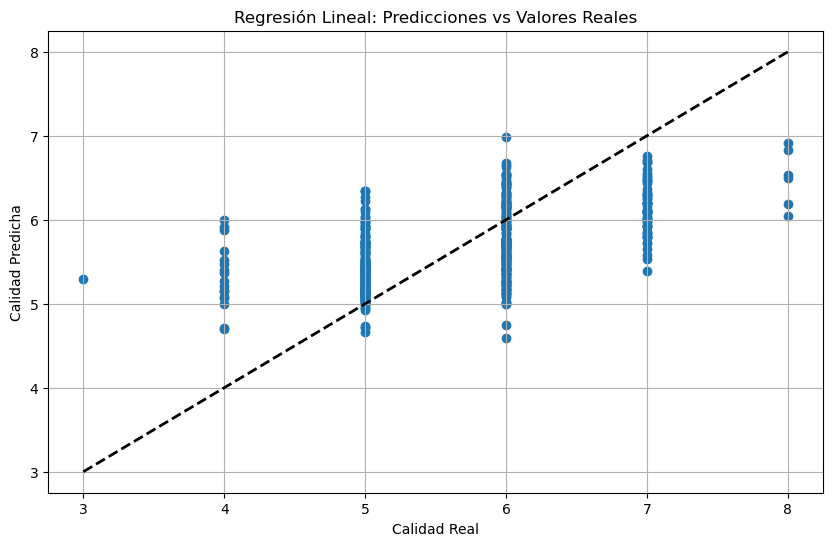

In [102]:
# Gráfico de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_reg)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--', lw=2)
plt.xlabel('Calidad Real')
plt.ylabel('Calidad Predicha')
plt.title('Regresión Lineal: Predicciones vs Valores Reales')
plt.grid(True)
plt.show()

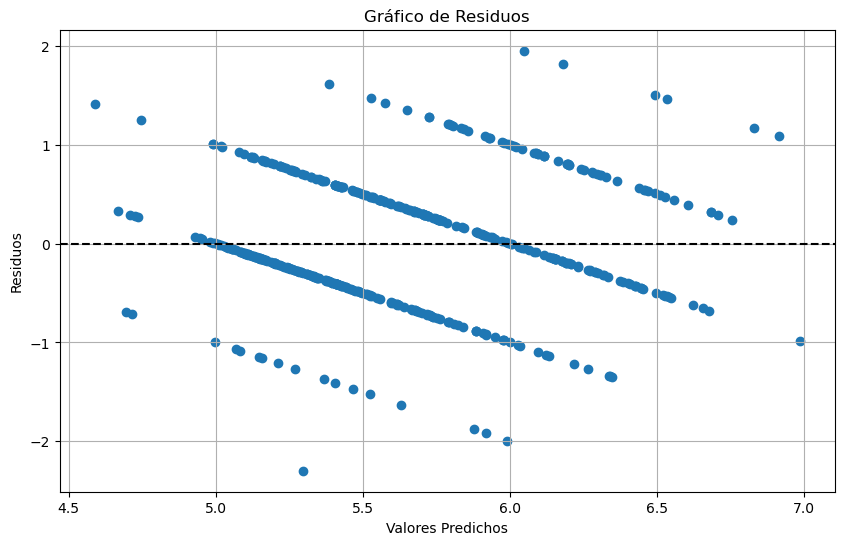

In [104]:
# Gráfico de residuos
residuals = y_test_reg - y_pred_reg
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_reg, residuals)
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.grid(True)
plt.show()

In [ ]:
# 7.2 REGRESIÓN LOGÍSTICA

Mejores hiperparámetros: {'C': 0.01, 'max_iter': 100, 'solver': 'lbfgs'}
Exactitud (Accuracy): 0.7188

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.67      0.71      0.69       213
           1       0.76      0.73      0.74       267

    accuracy                           0.72       480
   macro avg       0.72      0.72      0.72       480
weighted avg       0.72      0.72      0.72       480



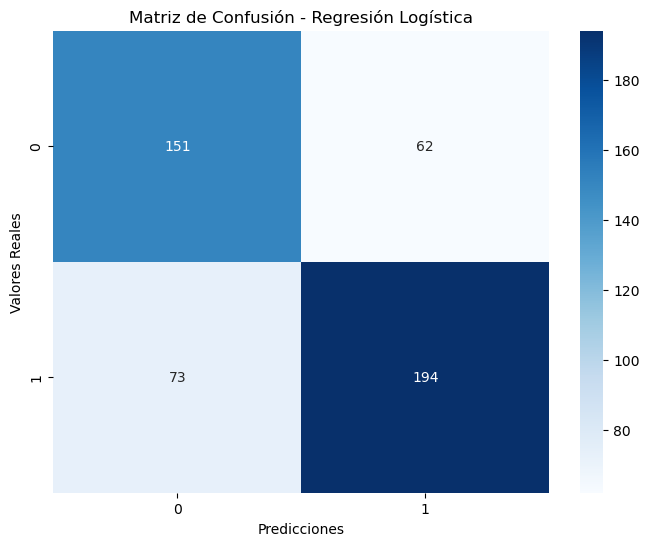

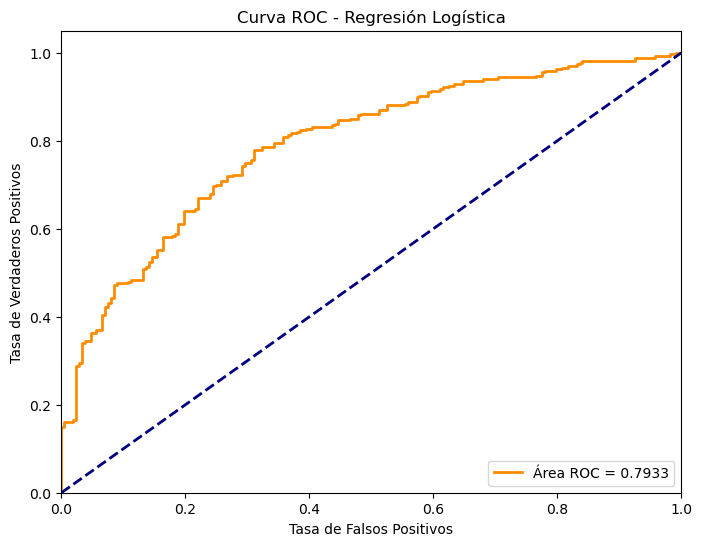

In [106]:
# Entrenamiento del modelo con búsqueda de hiperparámetros
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [100, 200, 300]
}

grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_log_scaled, y_train_log)

# Mejor modelo
best_log_model = grid_search.best_estimator_
print(f"Mejores hiperparámetros: {grid_search.best_params_}")

# Predicciones
y_pred_log = best_log_model.predict(X_test_log_scaled)

# Evaluación del modelo
accuracy = accuracy_score(y_test_log, y_pred_log)
print(f"Exactitud (Accuracy): {accuracy:.4f}")
print("\nInforme de clasificación:")
print(classification_report(y_test_log, y_pred_log))

# Matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_log, y_pred_log)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión - Regresión Logística')
plt.show()

# Curva ROC
from sklearn.metrics import roc_curve, auc
y_pred_proba = best_log_model.predict_proba(X_test_log_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_log, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Área ROC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Regresión Logística')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# 7.3 ÁRBOL DE DECISIÓN

Mejores hiperparámetros: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}
Exactitud (Accuracy): 0.7188

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.68      0.69      0.69       213
           1       0.75      0.74      0.75       267

    accuracy                           0.72       480
   macro avg       0.72      0.72      0.72       480
weighted avg       0.72      0.72      0.72       480



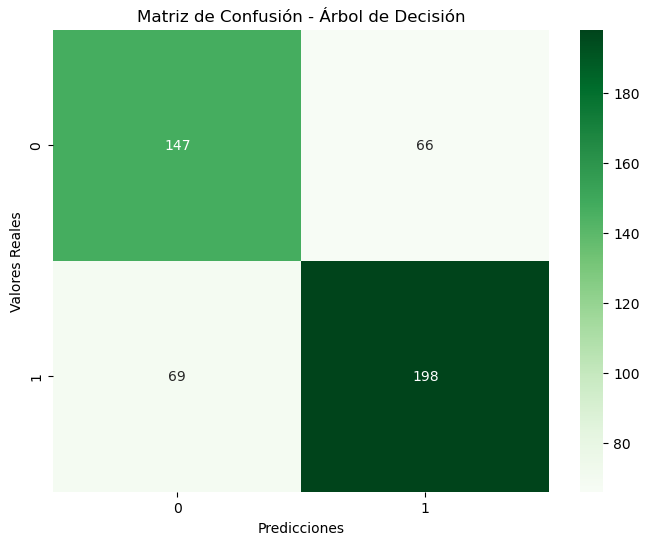

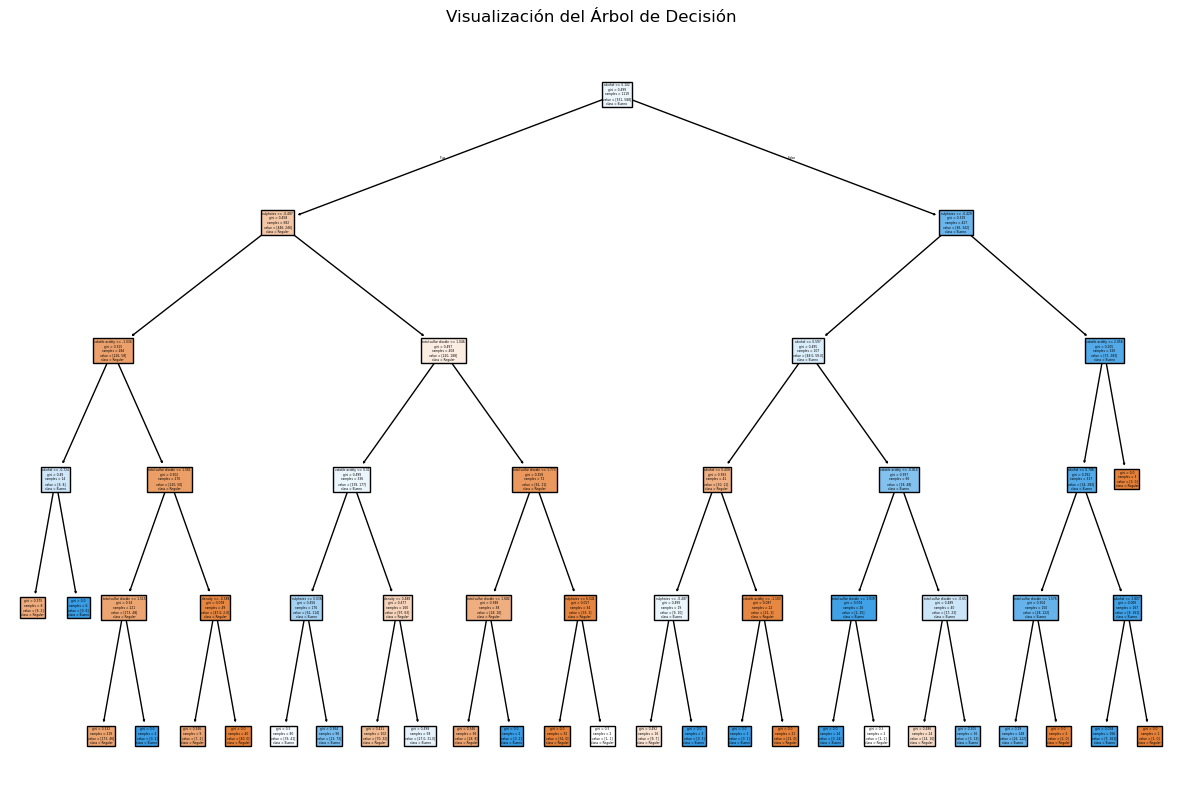

<Figure size 1000x600 with 0 Axes>

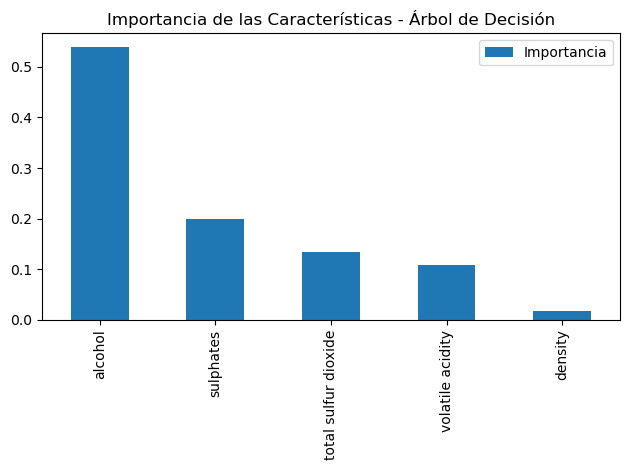

In [108]:
# Entrenamiento del modelo con búsqueda de hiperparámetros
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tree_scaled, y_train_tree)

# Mejor modelo
best_tree_model = grid_search.best_estimator_
print(f"Mejores hiperparámetros: {grid_search.best_params_}")

# Predicciones
y_pred_tree = best_tree_model.predict(X_test_tree_scaled)

# Evaluación del modelo
accuracy = accuracy_score(y_test_tree, y_pred_tree)
print(f"Exactitud (Accuracy): {accuracy:.4f}")
print("\nInforme de clasificación:")
print(classification_report(y_test_tree, y_pred_tree))

# Matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_tree, y_pred_tree)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión - Árbol de Decisión')
plt.show()

# Visualización del árbol de decisión
plt.figure(figsize=(15, 10))
plot_tree(best_tree_model, filled=True, feature_names=list(selected_features_tree), class_names=['Regular', 'Bueno'])
plt.title('Visualización del Árbol de Decisión')
plt.show()

# Importancia de características
feature_importance = pd.DataFrame(
    best_tree_model.feature_importances_,
    index=selected_features_tree,
    columns=['Importancia']
).sort_values('Importancia', ascending=False)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title('Importancia de las Características - Árbol de Decisión')
plt.tight_layout()
plt.show()

In [ ]:
# 8. COMPARACIÓN DE MODELOS

Exactitud Regresión Lineal (binarizada): 0.7375
Exactitud Regresión Logística: 0.7188
Exactitud Árbol de Decisión: 0.7188


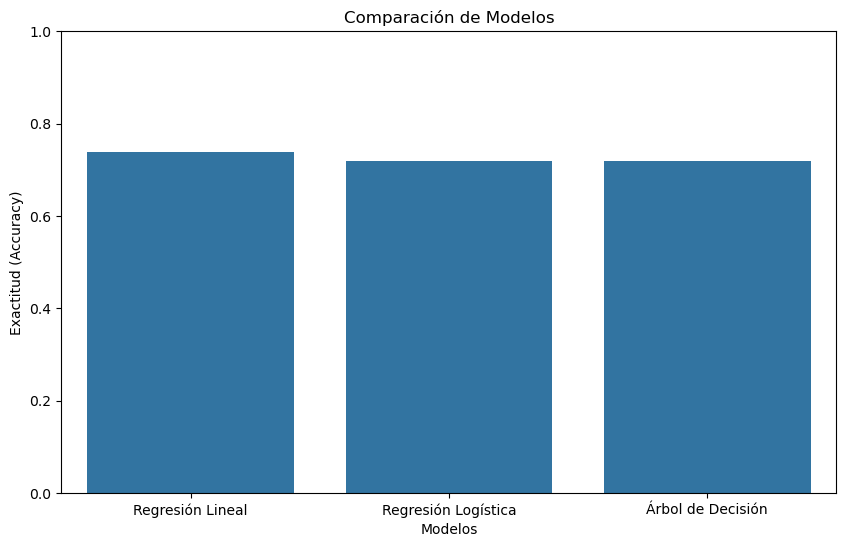

In [110]:
# Para la comparación, necesitamos convertir las predicciones de regresión lineal en clases
# Redondeamos las predicciones y las convertimos en binarias (>=6 es "bueno")
y_pred_reg_rounded = np.round(y_pred_reg)
y_pred_reg_binary = (y_pred_reg_rounded >= 6).astype(int)
y_test_reg_binary = (y_test_reg >= 6).astype(int)

# Calcular métricas comunes para todos los modelos
accuracy_reg = accuracy_score(y_test_reg_binary, y_pred_reg_binary)
accuracy_log = accuracy_score(y_test_log, y_pred_log)
accuracy_tree = accuracy_score(y_test_tree, y_pred_tree)

print(f"Exactitud Regresión Lineal (binarizada): {accuracy_reg:.4f}")
print(f"Exactitud Regresión Logística: {accuracy_log:.4f}")
print(f"Exactitud Árbol de Decisión: {accuracy_tree:.4f}")

# Gráfico comparativo
models = ['Regresión Lineal', 'Regresión Logística', 'Árbol de Decisión']
accuracies = [accuracy_reg, accuracy_log, accuracy_tree]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies)
plt.ylim(0, 1)
plt.xlabel('Modelos')
plt.ylabel('Exactitud (Accuracy)')
plt.title('Comparación de Modelos')
plt.show()


In [ ]:
9. CONCLUSIONES Y ANÁLISIS FINAL

In [ ]:
Según los coeficientes de la regresión lineal, las variables más importantes para predecir la calidad son:

Alcohol (0.326024): Impacto positivo significativo - a mayor contenido de alcohol, mayor calidad percibida.
Acidez volátil (-0.225139): Impacto negativo importante - niveles más altos de acidez volátil se asocian con menor calidad.
Sulfatos (0.111754): Impacto positivo moderado - niveles más altos de sulfatos tienden a relacionarse con mejor calidad.
Dióxido de azufre total (-0.074174): Impacto negativo leve - cantidades mayores se asocian con calidad ligeramente inferior.
Ácido cítrico (-0.031824): Impacto negativo muy pequeño - efecto menor en la calidad.

5. Conclusiones Generales

Comparación de modelos: La regresión lineal (binarizada) supera ligeramente a los otros modelos con una exactitud del 73.75%, mientras que tanto la regresión logística como el árbol de decisión alcanzan un 71.88%.
Interpretabilidad:

La regresión lineal ofrece coeficientes claros que indican la importancia de cada característica.
El árbol de decisión proporciona reglas interpretables para clasificar vinos.
La regresión logística ofrece un equilibrio entre interpretabilidad y rendimiento.


Factores determinantes de la calidad:

El contenido de alcohol es el predictor más importante de la calidad.
La acidez volátil (asociada con el sabor a vinagre) tiene un fuerte impacto negativo.
Los sulfatos (aditivos que contribuyen al dióxido de azufre, que actúa como antimicrobiano y antioxidante) tienen un impacto positivo en la calidad.


Limitaciones de los modelos:

El R² de 0.3267 sugiere que hay factores importantes que afectan la calidad del vino que no están incluidos en el dataset (como la edad, variedad de uva, región de cultivo, etc.).
La precisión de clasificación cercana al 72-74% indica que aún hay margen de mejora.